# Invistigating SIM-SKIP Refined Embeddings Performance in Detecting Reframings

## 0. Preface and Notes
In this file we try to decide if SIMSKIP Contrastive Refinement model is useful in detecting reframes. We will use SBERT to construct the intial embeddinngs, and SIM-SKIP to refine the embeddings.

### Approach
We Will try different techniques in using the model.
1. We will use [SBERT](https://sbert.net/), and later, both [SIMCSE](https://arxiv.org/abs/2104.08821), and [GTE](https://arxiv.org/abs/2308.03281) to create initial text embeddings, but initially we'll just use SBERT and then expand to the rest, since the last 2 models are contrastive learning models, we will use the reframings as positive examples, we can also use text augmentation and compare the two outputs.

2. We refine the embeddings using SIMSKIP, we do so in three approaches:  
  a. Using Reframings as positive examples.  
  b. Using data augmentations as Positive examples.  
  c. combining the reframing and the augmentation as positive examples.  
in all the previous approaches, all the other data are negative examples, we will begin by the last approach, and compare the results.  

3. We compare the performance of the baseline *- using only sBERT -* to the performance of each of the aforementioned refinements.

4. **The Process**:  
Get the embeddings for the sentence -> treat the simskip refinement as a spacial transformation that moves a sentence to its supposed reframing location -> Get cosine similarity between the reframing sBERT Embeddings, and sentence sBERT + SIM-SKIP (where we assume that simskip should have moved sentence embeddings to position of the reframings, we only train one model on the sentences to move them, while reframings' embeddings stay where they are.)

## 1. Setup


### 1.1 W&B

In [1]:
# if colab:
    # !pip install wandb onnx -Uq 

### 1.2 Libraries

In [2]:
import wandb
wandb.login()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
import ast
from tqdm import tqdm
import random

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: omaremaduldeen (omaremaduldeen-German International University - GIU). Use `wandb login --relogin` to force relogin
/Users/mero/miniconda3/envs/uulm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3 Configurations & Hyperparameters


In [55]:
# Config
config = dict(

    # Encoder Training
    epochs=2,
    batch_size=32,
    num_workers=0,
    learning_rate=0.001,
    weight_decay = 1e-4,
    temperature = 0.1,
    dropout_rate = 0.1,

    # Early Stopping
    patience = 10,
    delta = 0.01,
    
    # Classification head
    mlp_epochs = 20,
    projection_dim = 128,
    negative_samples_count = 2,
    classifier_output_dim = 2,
    classifier_hidden_dim = 1024,
    classifier_dropout = 0.1,
    classifier_learning_rate = 0.001,

    # Data
    dataset_folder='/Users/mero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Work/Ulm/Datasets/small_set',
    dataset_name="reframing_dataset.csv",
    text_model="all-mpnet-base-v2",
    input_dim = 768,
    downloaded = True,
    
    best_model_path ='models/best_model.pth',
    best_mlp_path ='models/best_mlp.pth',
    
    is_wandb_watching = False,
    colab = False
    )

In [4]:
# Reproducibility
torch.use_deterministic_algorithms(True, warn_only=True)
torch.manual_seed(42)
np.random.seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

In [5]:
# Setting some global configurations from the config
downloaded = config['downloaded']
colab = config['colab']
is_wandb_watching = config['is_wandb_watching']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 1.4 Models

#### 1.4.1 sBERT

In [7]:
if not config['downloaded']:
  #if colab:
    #!pip install -U sentence-transformers

  from sentence_transformers import SentenceTransformer
  from sentence_transformers.cross_encoder import CrossEncoder

## 2. Data & Build
Since each two sentences are the same we would add two positive reframing and get only half the length to avoid duplicates, and to assure that the negative examples don't include a reframing of the same sentence.

### Preparing needed Functions

In [8]:
def get_embeddings(path, text_model, download = False):
    """
    gets the embeddings of text from a specific model, keeps in mind the final
    needed data shape, mostly used when data is not downloaded.

    Args:
      path: filepath of the text data.
      text_model: the model to use to get the embeddings.
      download: if True, downloads the embeddings.

    Returns:
    Dataframe: containing the embeddings.
    """
    raw_data_df = pd.read_csv(path)

    # creating columns for sentences, and both reframings
    organised_data_df =  pd.DataFrame({'thought' : raw_data_df.iloc[::2, 1].values,
                                     'reframing1' : raw_data_df.iloc[::2, 2].values,
                                     'reframing2' : raw_data_df.iloc[1::2, 2].values
                                     })

    # Creating Embeddings
    sentence_embeddings = [text_model.encode(text).tolist() for text in organised_data_df['thought'].tolist()]
    reframing1_embeddings = [text_model.encode(text).tolist() for text in organised_data_df['reframing1'].tolist()]
    reframing2_embeddings = [text_model.encode(text).tolist() for text in organised_data_df['reframing2'].tolist()]


    embedded_data_df = pd.DataFrame({
        'thought': organised_data_df['thought'],
        'sentence_embedding': sentence_embeddings,

        'reframing1': organised_data_df['reframing1'],
        'reframing1_embedding': reframing1_embeddings,

        'reframing2': organised_data_df['reframing2'],
        'reframing2_embedding': reframing2_embeddings
    })

    if download:
      embedded_data_df.to_csv(os.path.join(config['dataset_folder'], 'reframing_dataset_embeddings.csv'), index=False)

    return embedded_data_df


In [9]:
def split_data(embedded_data_df, dataset_folder_path = config['dataset_folder']):

  """
    Split the embedded data into training, validation, and test sets, and downloads them as CSV files.

    This function performs the following operations:
    1. Splits the input dataframe into 80% training and 20% temporary data.
    2. Further splits the temporary data into 40% validation and 60% test data.
    3. Saves the resulting datasets as CSV files.
    4. Prints the size of each dataset.

    Args:
        embedded_data_df (pandas.DataFrame): The input dataframe containing embedded data.
        dataset_folder_path (str): The path to the folder where the CSV files will be saved.

    Returns:
        tuple: A tuple containing three pandas DataFrames (train_df, val_df, test_df).

    Side effects:
        - Creates 'train_vectors.csv', 'val_vectors.csv', and 'test_vectors.csv' files.
        - Prints the size of each dataset to the console.
    """
    
  # Split the data into training, validation, and test sets
  train_df, temp_df = train_test_split(embedded_data_df, test_size=0.2, random_state=42)
  val_df, test_df = train_test_split(temp_df, test_size=0.75, random_state=42)
  
  # Save the datasets as CSV files
  train_df.to_csv(os.path.join(dataset_folder_path, 'train_vectors.csv'), index=False)
  val_df.to_csv(os.path.join(dataset_folder_path, 'val_vectors.csv'), index=False)
  test_df.to_csv(os.path.join(dataset_folder_path, 'test_vectors.csv'), index=False)

  print(f"Training set size: {len(train_df)}")
  print(f"Validation set size: {len(val_df)}")
  print(f"Test set size: {len(test_df)}")
  return train_df, val_df, test_df


In [10]:
def get_datasets(embedded_data_df):

    """
    Split the embedded data and create train, validation, and test datasets.

    This function performs the following steps:
    1. Splits the input dataframe into train, validation, and test sets.
    2. Creates appropriate dataset objects for each split.

    Args:
        embedded_data_df (pandas.DataFrame): The input dataframe containing
                                             embedded data.

    Returns:
        tuple: A tuple containing three dataset objects (train_dataset, validation_dataset, test_dataset).

    Note:
        This function uses the predefined `split_data` Method, and assumes
        `ReframingTrainDataset`, and `ReframingTestDataset` classes are
        suitably defined.
    """

    # Splitting the data and downloading the splits
    train_data_df, validation_data_df, test_data_df = split_data(embedded_data_df)

    # building the datasets
    train_dataset = ReframingTrainDataset(train_data_df)
    validation_dataset = ReframingTestDataset(validation_data_df)
    test_dataset = ReframingTestDataset(test_data_df)

    return train_dataset, validation_dataset, test_dataset

In [11]:
def make_loader(data, batch_size, num_workers, shuffle = True):
    """
    Create a DataLoader for the given dataset.

    This function creates a PyTorch DataLoader with specified parameters,
    including custom worker initialization for reproducibility.

    Args:
        data (Dataset): The dataset to load.
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of subprocesses to use for data loading.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.

    Returns:
        DataLoader: A PyTorch DataLoader object.

    Note:
        This function assumes the existence of a `seed_worker` function and a
        generator `g` for reproducibility, which should be defined elsewhere
        in the code.
    """

    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=0, worker_init_fn=seed_worker,
    generator=g)
    return dataloader

### 2.1 Data Augmentations
The paper proposes two data augmentations techniques, that's what we will implement here.

Applying the augmentation to the positive examples provides us with twice as much positive examples for each item.

Later on we can use a paraphrasor and a positive reframer on the data to get more examples

In [12]:
def masked_augmentation(x, mask_ratio = 0.2):
  mask = torch.bernoulli(torch.full(x.shape, 1- mask_ratio)).bool()
  return x * mask


In [13]:
def gaussian_noise_augmentation(x, mean=0, std=0.13): #values used in the paper
  return x + torch.randn_like(x) * std + mean

In [14]:
def composite_augmentation(x, mask_ratio = 0.2, mean=0, std=0.13): #applies both augmentations to the same example
  mask = torch.bernoulli(torch.full(x.shape, 1- mask_ratio)).bool()
  x_masked = x * mask
  return x_masked + torch.randn_like(x) * std + mean

### 2.2 Creating dataset class

#### 2.2.1 Defining the Training Dataset Class

In [15]:
class ReframingTrainDataset(Dataset):
  def __init__(self, data, transform = None):
    self.transform = transform
    self.data = data

  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx): # On the modified data, where each item has 3 examples not the melted one
    if torch.is_tensor(idx):
      idx = idx.tolist()

   # Get the embeddings for the current index
    sentence_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['sentence_embedding']))
    reframing1_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['reframing1_embedding']))
    reframing2_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['reframing2_embedding']))
    
    # Get the text
    sentence_text = self.data.iloc[idx]['sentence']
    reframing1_text = self.data.iloc[idx]['reframing1']
    reframing2_text = self.data.iloc[idx]['reframing2']

    sample = {
            'sentence_embedding': sentence_embedding,
            'reframing1_embedding': reframing1_embedding,
            'reframing2_embedding': reframing2_embedding
        }

    if self.transform:
      sample = self.transform(sample)
    
    items = (
            sample['sentence_embedding'],
            sample['reframing1_embedding'],
            sample['reframing2_embedding'],       
        )

    return items




# The following code uses the melted dataframes, and treats the reframing and
# sentences separately, and uses the labels to determine the positive examples.
# This maybe used later, but now we use a different technique
"""def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    sentence = self.data.iloc[idx, 0]
    reframing1 = self.data.iloc[idx, 1]
    reframing2 = self.data.iloc[idx, 2]

    embeddings = self.textModel.encode([sentence, reframing1, reframing2])

    sample = {'thought': embeddings[0],'reframing1': embeddings[1],  'reframing2': embeddings[2]}

    if self.transform:
      sample = self.transform(sample)

    return sample"""


"def __getitem__(self, idx):\n    if torch.is_tensor(idx):\n      idx = idx.tolist()\n\n    sentence = self.data.iloc[idx, 0]\n    reframing1 = self.data.iloc[idx, 1]\n    reframing2 = self.data.iloc[idx, 2]\n\n    embeddings = self.textModel.encode([sentence, reframing1, reframing2])\n\n    sample = {'thought': embeddings[0],'reframing1': embeddings[1],  'reframing2': embeddings[2]}\n\n    if self.transform:\n      sample = self.transform(sample)\n\n    return sample"

#### 2.2.2 Defining the Validation & Testing Dataset Class

In [16]:
class ReframingTestDataset(Dataset):
  def __init__(self, data, transform = None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    # Get the embeddings for the current index
    sentence_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['sentence_embedding']))
    reframing1_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['reframing1_embedding']))
    reframing2_embedding = torch.tensor(ast.literal_eval(self.data.iloc[idx]['reframing2_embedding']))
    
    # get the text
    sentence_text = self.data.iloc[idx]['sentence']
    reframing1_text = self.data.iloc[idx]['reframing1']
    reframing2_text = self.data.iloc[idx]['reframing2']

    sample = {'sentence_text': sentence_text, 'sentence_embedding': sentence_embedding,
              'reframing1_text': reframing1_text, 'reframing1_embedding': reframing1_embedding,
              'reframing2_text': reframing2_text, 'reframing2_embedding': reframing2_embedding}

    if self.transform:
      sample = self.transform(sample)

    text = (sample['sentence_text'],
            sample['reframing1_text'],
            sample['reframing2_text']
    )
    embeddings = (sample['sentence_embedding'],
                  sample['reframing1_embedding'],
                  sample['reframing2_embedding']
    )

    return text, embeddings

## Utils
Helper function that will be later used

### Helper Functions

#### Text Pairing

In [17]:
def create_pairs(thoughts, reframings, num_negatives = 2, shuffle = False):
    """
    Creates both positive and negative pairs and combines them into a single dataset.

    Args:
        thoughts (Tensor): Batch of thought tensors.
        reframings (Tensor): Batch of all concatenated reframings tensors.
        negative_samples_count (int, optional): Number of negative samples per sentence. Default is 2.

    Returns:
        dict: Dictionary with combined positive and negative pairs.
        Tensor: Combined labels tensor.
        Tensor: Tensor of the indices of the positives where the fifth element is the value of the index of the reframing corresponding to the fifth sentnence in the positive pairs.
        Tensor: Tensor of the indices of the negatives where the fifth element is the value of the index of the reframing corresponding to the fifth sentnence in the negative pairs.
    """
    # To avoid mlp affecting encooder weights
    thoughts = thoughts.detach()
    reframings = reframings.detach()

    # Create positive and negative pairs separately
    positive_pairs, positive_labels, pos_indices = create_positive_pairs(thoughts, reframings)
    negative_pairs, negative_labels, neg_indices = create_negative_pairs(thoughts, reframings, num_negatives)

    # Combine positive and negative pairs
    combined_pairs = {
        'thought': torch.cat((positive_pairs['thought'], negative_pairs['thought']), dim=0),
        'reframing': torch.cat((positive_pairs['reframing'], negative_pairs['reframing']), dim=0)
    }
    combined_labels = torch.cat((positive_labels, negative_labels), dim=0).to(device)

    if shuffle:
        # Shuffle the combined pairs and labels
        shuffled_pairs, shuffled_labels, shuffled_indices = shuffle_pairs_and_labels(combined_pairs, combined_labels)
        return shuffled_pairs, shuffled_labels


    return combined_pairs, combined_labels, pos_indices, neg_indices


def create_positive_pairs(thoughts, reframings):
    """
    Creates positive pairs from sentences and reframings. it keeps track
    of the indices of the positives, so we can retrieve the text of
    the pairs later.

    Args:
        thoughts (Tensor): Batch of thoughts tensors.
        reframings (Tensor): Batch of all reframings combined tensors.

    Returns:
        dict: Dictionary with positive pairs.
        Tensor: Tensor of positive labels.

    """
    num_samples = thoughts.shape[0]
    positives_per_thought = reframings.shape[0] // num_samples

    thoughts_repeated = thoughts.repeat(positives_per_thought, 1)

    positive_labels = torch.ones(reframings.shape[0], dtype=torch.long).to(device)
    pos_indices = torch.arange(reframings.shape[0])

    positive_pairs = {
        'thought': thoughts_repeated,
        'reframing': reframings
    }
    return positive_pairs, positive_labels, pos_indices


def create_negative_pairs(thoughts, reframings, negative_samples_count):
    """
    Creates negative pairs by selecting random reframings that are not
    true matches. it keeps track of the indices of the negatives, so we
    can retrieve the text of the pairs later.

    Args:
        thoughts (Tensor): Batch of thoughts tensors.
        reframings (Tensor): Batch of all reframings combined tensors.
        negative_samples_count (int): Number of negative samples per sentence.

    Returns:
        dict: Dictionary with negative pairs.
        Tensor: Tensor of negative labels.
        Tensor: Tensor of the negative indices.
    """
    num_samples = thoughts.shape[0]
    positives_per_thought = reframings.shape[0] // num_samples

    thoughts_repeated = thoughts.repeat(negative_samples_count, 1)

    neg_indices = torch.randint(0, reframings.shape[0], (num_samples * negative_samples_count,))
    true_indices = torch.arange(num_samples).repeat(negative_samples_count)

    # Ensure negative indices won't lead to positive examples
    mask = neg_indices % num_samples == true_indices
    while mask.any():
        neg_indices[mask] = torch.randint(0, reframings.shape[0], (mask.sum().item(),))
        mask = neg_indices % num_samples == true_indices

    negative_reframings = reframings[neg_indices]
    negative_labels = torch.zeros(num_samples * negative_samples_count, dtype=torch.long).to(device)

    negative_pairs = {
        'thought': thoughts_repeated,
        'reframing': negative_reframings
    }
    return negative_pairs, negative_labels , neg_indices

In [18]:
def pair_text(thoughts_text, reframings_text, pos_indices, neg_indices):
  """
  Pairs the sentences text with their positive and negative reframings that
  were created in the negative and positive examples step, will be used to
  visualise the results.
  This sort of traces the steps we did when creating positive and negative
  examples from embeddings in 'create_pairs' function, but this time on the
  text itself.

  Args:
    thoughts_text: The thoughts text.
    reframings_text: The reframings text.
    pos_indices: indices relating each sentence from the positive examples to its reframing.
    neg_indices: indices relating each sentence from the negative examples to its reframing.

  Returns:
    dict: containing each sentence along side its corresponding reframing.

  """
  # Convert to list
  thoughts_text = list(thoughts_text)
  reframings_combined = list(reframings_text)

  negatives_per_sent = len(neg_indices) // len(thoughts_text)

  positive_reframings = [reframings_combined[i] for i in pos_indices]
  negative_reframings = [reframings_combined[i] for i in neg_indices]

  refarmings = positive_reframings + negative_reframings

  thoughts_pos = thoughts_text * 2
  thoughts_neg = thoughts_text * negatives_per_sent
  thoughts = thoughts_pos + thoughts_neg

  pairs = {
      'thought': thoughts,
      'reframing': refarmings
  }
  label = [1] * len(positive_reframings) + [0] * len(negative_reframings)
  pairs['label'] = label
  
  pairs_df = pd.DataFrame(pairs)
  if is_wandb_watching:
    wandb.log({"pairs": wandb.Table(dataframe=pairs_df)})
  
  return pairs

In [19]:
def shuffle_pairs_and_labels(pairs, labels):
        """
        Shuffles pairs and labels together, and returns the shuffled indices
        to keep track of the data.

        Args:
            pairs (dict): Dictionary containing 'thought'nd 'reframing' tensors.
            labels (Tensor): Labels tensor.

        Returns:
            dict: Shuffled pairs dictionary.
            Tensor: Shuffled labels tensor.
        """
        indices = torch.randperm(len(pairs['thought']))
        pairs['thought'] = pairs['thought'][indices]
        pairs['reframing'] = pairs['reframing'][indices]
        labels = labels[indices]
        return pairs, labels, indices

#### Metrics & Evaluation

In [20]:
def get_metrics_from_predictions(y_true, y_pred):
    """
    Calculate various metrics from the true and predicted labels.

    This function calculates the following metrics:
    - F1 Score
    - Accuracy
    - Precision
    - Recall
    - Confusion Matrix components

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion.ravel()
    
    metrics = {
        'acc': accuracy,
        'prec': precision,
        'recall': recall,
        'f1': f1,
        'confusion': confusion,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
    }

    return metrics

### Plotting & Logging

In [21]:
def encoder_train_log(loss, val_loss, example_count, epoch, is_logging_epoch = False):
    """
    Logs training and validation losses to WandB.

    Args:
        loss (float): Training loss.
        val_loss (float): Validation loss.
        example_count (int): Number of examples seen.
        epoch (int): Current epoch.
    """
    if is_logging_epoch:
        print(f"Epoch {epoch + 1}/{config['epochs']}, Average Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")
        print(['='*10])
        print('\n')
    else:
        if is_wandb_watching:
            wandb.log({
                "epoch": epoch,
                "model_batch_train_loss": loss,
                "model_batch_validation_loss": val_loss,
            })
        print(f"Loss after {str(example_count).zfill(5)} examples: train = {loss:.3f} || validation = {val_loss:.3f}")

In [22]:
def log_metrics(metrics, prefix='', log = True, print = True):
    """
    Log the metrics to the console and to Weights & Biases.

    This function logs the metrics to the console and to Weights & Biases
    using the `wandb.log` method.

    Args:
        metrics (dict): A dictionary containing the metrics to log.
        prefix (str): An optional prefix to add to the metric names.
    """

    for key, value in metrics.items():
        key = f'{prefix}/{key}'
        if log:
            wandb.log({key: value})
        if print:
            print(f'{key}: {value}')

#### UMAP

In [23]:
def umap_validation(validation_loader, encoder_model):
    # get all the validation data
    thoughts_text, thoughts_embedding, reframing1_text, reframing1_embedding, reframing2_text, reframing2_embedding = [tuple[0] for tuple in zip(*[batch for batch in iter(validation_loader)])]

    validation_umap = None


    

In [24]:
def get_umap_dimensions(embeddings, text=None, epoch = -1):
    """
    Perform UMAP dimensionality reduction on the given vectors.

    Parameters:
    embeddings (tuple): Tuple containing the sentence, reframing1, and reframing2 vectorised embeddings.
    text (tuple, optional): Tuple containing the sentence, reframing1, and reframing2 text. Defaults to None, would be used as info for the hovering later.
    epoch (int, optional): The epoch number. Defaults to -1 if not related to epoch.

    Returns:
    tuple: Tuple containing the UMAP embeddings, UMAP DataFrame, and index.
    """
    sentences_embedding, reframing1_embedding, reframing2_embedding = embeddings

    # Create identifier to distinguish corresponding reframings with sentences.
    index = torch.arange(len(sentences_embedding)).repeat(3)

    # Concatenate all elements
    all_vectors = torch.cat([sentences_embedding, reframing1_embedding, reframing2_embedding], dim=0)

    # Perform UMAP dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=2, min_dist=0.3, metric='cosine').fit_transform(all_vectors.cpu().numpy())

    # Create a DataFrame for UMAP embeddings
    umap_df = pd.DataFrame(umap_embeddings, columns=['x-rep', 'y-rep'])
    umap_df['Type'] = ['thought'] * len(sentences_embedding) + \
                      ['Reframing 1'] * len(reframing1_embedding) + \
                      ['Reframing 2'] * len(reframing2_embedding)  # To differentiate in plotting
    umap_df['Index'] = index
    umap_df['epoch'] = [epoch] * len(umap_df)
    
    
    if text:
        sentences_text, reframing1_text, reframing2_text = text
        all_text = sentences_text + reframing1_text + reframing2_text
        umap_df['Text'] = all_text

    return umap_df


def plot_umap_representation(umap_df, title, show = True):
    """
    Plot the UMAP representation using Plotly.

    Parameters:
    umap_embeddings (numpy.ndarray): The UMAP embeddings.
    umap_df (pandas.DataFrame): The UMAP DataFrame.
    title (str): Title for the plot.
    text (tuple, optional): Tuple containing the sentence, reframing1, and reframing2 text. Defaults to None.
    show (bool, optional): Flag indicating whether to display the plot immediately. Defaults to True.

    Returns:
    None
    """
    plot_title = title

    # Plot UMAP embeddings using Plotly
    fig = px.scatter(umap_df,
                     x='x-rep',
                     y='y-rep',
                     color='Index',
                     title=plot_title,
                     opacity=0.8,
                     hover_data=['Index', 'Text'],
                     symbol='Index',
                     animation_frame = 'epoch'
                    )
    # customizing the colourbar layout
    fig.update_layout(
        coloraxis_colorbar=dict(
            title='Index',
            yanchor="bottom",
            y=-0.5,
            x=0.5,
            ticks="outside",
            orientation="h"
        )
    )

    log_title = title + " UMAP Dimensions"
    reduced_dimensions = wandb.Table(dataframe=umap_df)
    if is_wandb_watching:
        wandb.log({title: fig, log_title: reduced_dimensions})

    if show:
        fig.show()

## 3. Defining SIM-SKIP Architecture

### 3.1 Defining Loss Function

In [25]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1, include_thoughts_as_negatives = True):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.include_thoughts_as_negatives = include_thoughts_as_negatives
        
    def forward(self, thoughts, reframings):
        dim = thoughts.shape[1]
        batch_size = thoughts.shape[0]
        positives_per_thought = reframings.shape[0] // batch_size

        # Combine thoughts and reframings into a single tensor, this is so we can include other thoughts as negatives for each thought
        features = torch.cat([thoughts, reframings], dim=0)
        
        # normalize the vectors to get cosine similarity later by matrix multiplication
        features_norm = nn.functional.normalize(features, dim=1)
        
        # Create the labels this is similar to having a class for each thought and its reframings
        # later we will construct the targets/poisitve masks by matching the labels
        labels = torch.arange(batch_size).repeat(positives_per_thought+1).to(device)
        
        # Create mask for removing self similarities, this mask will exclude them from calculations
        N = batch_size * (positives_per_thought+1) # this to inchude the thoughts and reframings
        mask = torch.eye(N, device=device).bool()
        
        # Remove thoughts indices from calculations if we want to only compare thoughts to reframings in training
        if not self.include_thoughts_as_negatives:
            # Exclude thought-to-thought comparisons
            thoughts_indices = torch.arange(batch_size)
            thoughts_mask = torch.zeros_like(mask)
            thoughts_mask[thoughts_indices.unsqueeze(1), thoughts_indices.unsqueeze(0)] = True
            mask = mask | thoughts_mask
        
        
        # calculate the cosine similarity, and apply the temperature scaling
        similarity_matrix = torch.matmul(features_norm, features_norm.T) / self.temperature
        
        # Adjust the similarities for numerical stability, later on when using logarithms.
        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        logits = similarity_matrix - logits_max.detach()
        
        # Remove excluded similarities we decided before in the mask, and then get the log probability
        ## This calculation uses the log identitiy log(a/b) = log(a) - log(b), and log(exp(a)) = a
        ## the nominator of the loss function is thus just the similarity of the positive examples (logits)
        logits_masked = logits.masked_fill(mask, float('-inf')) # as exp(-inf) = 0
        log_prob = logits - torch.logsumexp(logits_masked, dim=1, keepdim=True)
        

        # Define the targets
        ## The targets represent the location of positive examples in the logits matrix as ones, and zeros elsewhere
        ## We will use the previously created labels to find areas of agreement. Note that currently targets will remain
        ## a boolean with the same shape as the logits matrix, but we will use it as a positives_mask later on.
        labels = labels.unsqueeze(0)
        targets = labels == labels.T
        targets = targets & ~mask # remove the excluded similarities


        # This will get us the sum of the positives only for each thought, and then we nomralise by the number of positives
        mean_log_prob_pos = (targets.float() * log_prob).sum(dim=1) / targets.float().sum(dim=1)

        # The loss is the sum of previous operations across the batch
        # Here we use the mean instead of sum as we don't want the batch size to affect the loss and gradients-
        #  magnitude, this helps with numerical stability and is common practice,
        loss = - mean_log_prob_pos
        loss = loss.mean()

        return loss


### 3.2 Encoder Architecture

In [26]:
class SimSkipEncoder(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super(SimSkipEncoder, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Linear(input_dim, input_dim // 2),
        nn.BatchNorm1d(input_dim // 2, eps = 1e-4),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(input_dim // 2, input_dim),
            nn.BatchNorm1d(input_dim, eps = 1e-4),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        identity = x
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.linear(x)
        return x + identity # The skip connection

### 3.3 Projector Architecture

In [27]:
class SimSkipProjector(nn.Module):
    def __init__(self, input_dim, projection_dim):
        super(SimSkipProjector, self).__init__()
        self.layer1 = nn.Linear(input_dim, input_dim)
        self.layer2 = nn.Linear(input_dim, projection_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x) # Adds non linearity to the projection which should perform better.
        x = self.layer2(x)
        return x

### 3.4 SIM-SKIP Combined

In [28]:
class SimSkip(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1, projection_dim = 128, loss_temperature = 0.1, learning_rate = 0.001, weight_decay = 1e-4):
        super(SimSkip, self).__init__()
        self.encoder = SimSkipEncoder(input_dim, dropout_rate)
        self.projector = SimSkipProjector(input_dim, projection_dim)
        
        self.loss = ContrastiveLoss(temperature=loss_temperature)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                     lr=learning_rate,
                                     weight_decay = weight_decay
                                     )
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=config['epochs'])


    def forward(self, x, use_projector = None):
        def forward(self, x, use_projector=None):
            """
            Forward pass through the model.
            Parameters:
            x (torch.Tensor): Input tensor to the model.
            use_projector (bool, optional): Flag to determine whether to use the projector. 
                                            If None, defaults to using the projector during training.
                                            This is mostly when needing to force using the projector while evaluating,
                                            e.g. for loss calculation.
            Returns:
            torch.Tensor: Output tensor after passing through the encoder (and projector if applicable).
            """
        
        if self.training or use_projector:
          x = self.encoder(x)
          x = self.projector(x)
        else:
          # if we are evaluating, we don't need gradients, this also ensures that training the linear classifier doesn't extend to the encoder
          with torch.no_grad():
            x = self.encoder(x)
        return x
      
    
    def training_step(self, batch):
        self.train()

        # Unpack the batch
        thoughts = batch[0].to(device) 
        reframings = torch.cat(batch[1:], dim = 0).to(device)
        
        # Encode the Batch
        thoughts_encoded = self(thoughts)
        reframings_encoded = self(reframings)

        # Forward pass
        self.optimizer.zero_grad()

        loss = self.loss(thoughts_encoded, reframings_encoded)
        
        # Backward pass and optimization
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
      
    def validation_step(self, validation_loader):
        """
        This functon is the evaluation function for the model, it calculates the loss on the validation set. and 
        returns the loss.
        Args:
            validation_loader (DataLoader): the validation set dataloader.
            model (torch.nn.Module): The encoder model to evaluate.

        Returns:
            _type_: _description_
        """        
        
        sum_loss = 0
        num_batches = len(validation_loader)
        
        for batch in validation_loader:
            text, embeddings = batch
            thoughts, reframings = embeddings[0].to(device), torch.cat(embeddings[1:], dim = 0).to(device)
            # Set the model to training to get the loss after projection, as projection is disabled on evaluation
            self.eval()
            thoughts_encoded = self(thoughts, use_projector=True)
            reframings_encoded = self(reframings, use_projector=True)
            loss = self.loss(thoughts_encoded, reframings_encoded)
            sum_loss += loss

        avg_validation_loss = sum_loss / num_batches
        return avg_validation_loss

### 3.5 Classification Head

In [29]:

class ClassificationHead(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim=1024, 
                 output_dim=2, 
                 negative_samples_count= 2,
                 dropout_rate=0.05, 
                 learning_rate=0.01):
        """
        Initializes the classification head with a simple MLP.

        Args:
            input_dim (int): Dimension of the input features.
            hidden_dim (int, optional): Dimension of the hidden layer. Default is 1024.
            output_dim (int, optional): Dimension of the output layer. Default is 1.
            dropout_rate (float, optional): Dropout rate for regularization. Default is 0.1.
            negative_samples_count (int, optional): Number of negative samples per sentence. Default is 2.
            learning_rate (float, optional): Learning rate for the optimizer. Default is 0.01.
        """
        super(ClassificationHead, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = nn.Linear(2 * input_dim, hidden_dim) # Concatenated sentence and reframing embeddings
        self.layer2 = nn.Linear(hidden_dim, output_dim)


        self.negative_samples_count = negative_samples_count
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        """
        Forward pass through the MLP.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after passing through the MLP.
        """
        x = self.dropout(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        return x

    def predict(self, sentence1, sentence2, from_logits = True, cos_sim = False):
        """
        Makes predictions by passing concatenated sentence pairs through the model.

        Args:
            sentence1 (Tensor): First sentence tensor.
            sentence2 (Tensor): Second sentence tensor.
            from_logits (bool, optional): Whether to return logits or probabilities. Default is True (logits).
            cos_sim (bool, optional): Whether to use plaincosine similarity as the prediction, or the mlp itself. Default is False (mlp).

        Returns:
            Tensor: Predictions after applying the model.
        """
        sentence1 = sentence1.to(device)
        sentence2 = sentence2.to(device)
        
        if cos_sim:
            prediction = F.cosine_similarity(sentence1, sentence2, dim=1)
            prediction = torch.clamp(prediction, min=0, max=1)
            
        else:
            input = torch.cat([sentence1, sentence2], dim=1)
            prediction = self.forward(input)

            # gets the normalised predictions when not training
            if not from_logits:
                prediction = F.softmax(prediction, dim = 1)[:, 1] # probability of class 1
            
        return prediction


    def training_step(self, thoughts, reframings):
        """
        Defines the logic for a training step in the classification head.

        Args:
            thoughts (Tensor): Encoded thought embeddings.
            reframings (Tensor): Encoded reframing embeddings.

        Returns:
            Loss: (Tensor): Loss value for the current training step.
        """
        self.train()
        
        positives_per_thought = reframings.shape[0] // thoughts.shape[0]
        negative_samples_count = positives_per_thought # We use the same number of negatives as positives to assure balance
        
        pairs, labels, _, _ = create_pairs(thoughts, reframings, num_negatives = negative_samples_count)
        predictions = self.predict(pairs['thought'], pairs['reframing'])
        
        loss = self.loss(predictions, labels)
        
        # Zero the gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        self.optimizer.step()


        with torch.no_grad():
            # Get metrics
            metrics = self.evaluate_predictions(predictions, labels)
            
            # Normalise predictions to probability with softmax
            predictions = F.softmax(predictions, dim = 1)[: , 1] # probability of class 1, this acts as the probability of being true

        return metrics, predictions, labels
    
    
    def test_val_step(self, thoughts_embeddings, reframings_embeddings, cos_sim = False):
        """
        A function used to validate or test the model on a batch it provides insights and statistics about a given batch,
        the stats can be using the mlp itself or just plain cosine similarity, mostly used to compare the two.

        Args:
        thoughts_embeddings: The thoughts embeddings
        reframings_embeddings: The reframings embeddings
        cos_sim: a boolean indicating whether the model degrades to plain cosine similarity
                   usually used as some sort of baseline this is usually opposite to cos sim, as cos sim is 
                   never logits, but always actual probabilities.

        Returns:
          Tensor: loss value
          Tensor: predictions of the model for the pairs
          Tensor: ground truth labels for the pairs
            dict: indices of the positive pairs
            dict: indices of the negative pairs
            dict: evaluation metrics
        """
        positives_per_thought = reframings_embeddings.shape[0]//thoughts_embeddings.shape[0]
        
        pairs, labels, pos_indices, neg_indices = create_pairs(thoughts_embeddings, reframings_embeddings, num_negatives = positives_per_thought)
        
        # Get logits, as we'll calculate loss later, and the loss takes logits
        predictions = self.predict(pairs['thought'], pairs['reframing'], from_logits = True, cos_sim=cos_sim)
        
        # Get prediction metrics from the logits we got for plotting or evaluation.
        metrics = self.evaluate_predictions(predictions, labels, from_logits = not cos_sim)
        loss = metrics['value_loss']
        
        # Convert logits into predictions, cosine similarity doesn't have logits
        if not cos_sim:
            predictions = F.softmax(predictions, dim = 1)[:, 1] # probability of class 1, this acts as the probability of being true
        
        return loss, predictions, labels, pos_indices, neg_indices, metrics

    def on_train_epoch_end(self, val_loader, encoder_model):
        """
        Computes metrics on validation set at the end of a training epoch of the classification head.

        Args:
            val_loader (DataLoader): Validation data loader.
            encoder_model (nn Module): The model to encode the embeddings before predictions

        Returns:
            dict: Dictionary containing evaluation metrics.
        """
        # put encoder in eval mode, mostly to skip the projection
        encoder_model.eval()
        
        # Initialise empty tensors to collect all predictions and labels to plot them later
        all_predictions = torch.Tensor()
        all_labels = torch.Tensor()
        
        for batch_idx, batch in enumerate(val_loader):
            # Unpack the batch
            text, embeddings = batch
            
            thoughts_text = text[0]
            reframings_text = [reframing 
                            for reframings_set in text[1:] 
                            for reframing in reframings_set
                            ]
            
            thoughts_embeddings = embeddings[0].to(device)
            reframings_embeddings = torch.cat(embeddings[1:], dim = 0).to(device)

            positives_per_thought = reframings_embeddings.shape[0]//thoughts_embeddings.shape[0]

            # Record the predictions of the current training step for plotting later, and get prediction metrics
            loss, predictions, labels, pos_ind, neg_ind, metrics = self.test_val_step(thoughts_embeddings, reframings_embeddings)
            text_pairs = pair_text(thoughts_text, reframings_text, pos_ind, neg_ind)
            
            all_predictions = torch.cat((all_predictions, predictions))
            all_labels = torch.cat((all_labels, labels))

        return all_predictions, all_labels, metrics, text_pairs

    def evaluate_predictions(self, predictions, labels, threshold=0.5, from_logits = True, divide_cm = False):
        """
        Evaluates predictions using various metrics.

        Args:
            predictions (Tensor): logits predictions.
            labels (Tensor): True labels.
            threshold (float, optional): Threshold for converting logits to binary predictions. Default is 0.5.
            from_logits (bool, optional): Whether the inputted predictions are logits, defaults to True. If the input is predictions calculated by cosine similarity this will be False as well.
            divide_cm (bool, optional): Whether to divide the confusion matrix into its components. Default is False.

        Returns:
            dict: Dictionary containing evaluation metrics.
        """
        
        # Specify another loss function just in case the predictions are not logits,
        # but are already probabilities we don't want to use BCEWithLogits but normal BCE
        normalised_loss = nn.BCELoss()
        
        # Get the loss, we have 2 ways, either the predictions are logits then we can use the original one,
        # or they are already normalised to probabilities, in this case we use the already normalised loss.

        if from_logits:
            # calculate the loss from the logits, this will pass inputs to softmax before calculating the entropy
            val_loss = self.loss(predictions, labels).item()
            
            # Normalise predictions to get the prediction probabilities, to calculate metrics later
            predictions = F.softmax(predictions, dim = 1)[:, 1] # probability of class 1, this acts as the probability of being true
        else: 
            # We need to use something other then Cross entropy as here we have aready normalised predictions with softmax
            # Avoid log(0) by adding a small epsilon
            val_loss = nn.BCELoss()(predictions, labels.float()).item()


        # Get predictions as binary values
        inference = (predictions >= threshold).float()

        # Convert PyTorch tensors to NumPy arrays for sklearn metrics
        inference, labels = inference.detach().cpu().numpy(), labels.detach().cpu().numpy()

        # Calculate metrics
        metrics = {
            'value_loss': val_loss,
            'value_f1': f1_score(labels, inference),
            'value_acc': accuracy_score(labels, inference),
            'value_prec': precision_score(labels, inference, zero_division=0),
            'value_recall': recall_score(labels, inference),
            'value_confusion': confusion_matrix(labels, inference)
        }
        if divide_cm:
            metrics = {
            'value_loss': metrics['value_loss'],
            'value_f1': metrics['value_f1'],
            'value_acc': metrics['value_acc'],
            'value_prec': metrics['value_prec'],
            'value_recall': metrics['value_recall'],
            "true_positives": metrics['value_confusion'][1,1],
            "true_negatives": metrics['value_confusion'][0,0],
            "false_positives": metrics['value_confusion'][0,1],
            "false_negatives": metrics['value_confusion'][1,0]
            }
        return metrics

## 4. Defining Training Architecture


In [30]:
def get_targets(thoughts, positives):

    """
    Creates target labels for the prediction.

    Generates a target matrix where each row represents an thought and
    each column represents a potential positive example. Ones in the matrix
    indicate correct positive matches for each thought.

    Args:
        thoughts (torch.Tensor): Tensor of thought embeddings.
        positives (torch.Tensor): Tensor of positive embeddings.

    Returns:
        torch.Tensor: Target matrix for contrastive loss.
    """

    batch_size = int(thoughts.shape[0])
    positives_per_thought = int(positives.shape[0] / batch_size)

    # Create the identity matrix
    identity = torch.eye(batch_size)

    # Repeat the id matrix for every positive reframing
    targets = torch.cat([identity for _ in range(positives_per_thought)], dim=1)

    return targets

### 4.1 Early Stopping & Model Saving

In [31]:
class EarlyStopping:
    """
    Early stopping utility to stop training when validation loss does not improve.
    """
    def __init__(self, is_mlp = False, patience=7, delta=0, best_model_path = 'models/best_model.pth', best_mlp_path = 'models/best_mlp.pth'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.current_dir = os.getcwd()
        self.is_mlp = is_mlp
        self.best_model_path = best_mlp_path if is_mlp else best_model_path
        self.path = os.path.join(self.current_dir, self.best_model_path)

    def __call__(self, epoch, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch, val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(epoch, val_loss, model)

    def save_checkpoint(self, epoch, val_loss, model):
        """
        Saves the model if validation loss has decreased.

        Args:
            epoch (int): Current epoch.
            val_loss (float): Validation loss.
            model (torch.nn.Module): The model to save.
            path (str): Path to save the model.
        """
        path = self.path
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'validation_loss': val_loss
        }, path)
        
        print(f'Model at epoch{epoch} saved with validation loss of {val_loss:.5f}')


### 4.2 Train Functions

In [32]:
def train_model(model, dataloader, val_loader, config):
    """
    Trains the given model using the provided data loader, criterion, and optimizer.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        lr_scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        config (Namespace): Configuration object with training parameters.

    Returns:
        model (torch.nn.Module): The trained model.
        mlp_evaluator (ClassificationHead): The trained evaluator head.
    """

    model.to(device)
    model.train()
    if is_wandb_watching:
        wandb.watch(model, model.loss, log='all', log_freq=1)

    early_stopping = EarlyStopping(patience=config['patience'], delta=config['delta'])

    example_count = 0  # number of total examples seen
    batch_count = 0 # number of batches gone through
    
    # Later on we will plot the progress of embedding space improvement by plotting
    # reduced dimensions representation using umap, so here we initialise the vectors
    # to be populated later.
    umap_df = None

    for epoch in tqdm(range(config['epochs'])):
        total_train_loss = 0

        for batch in dataloader:
            model.train()

            loss = model.training_step(batch)
            total_train_loss += loss
            
            # calculate the validation loss
            val_loss = model.validation_step(val_loader)
        
            example_count += len(batch[0])
            batch_count += 1

            # Log Metrics
            if batch_count % 2 == 0:
                encoder_train_log(loss, val_loss, example_count, epoch)

        # Average losses
        avg_train_loss = total_train_loss / len(dataloader)
        val_loss = model.validation_step(val_loader)
        """# TODO: Add the UMAP logging function
        epoch_umap_df['epoch'] = [epoch] * len(epoch_umap_df)
        plot_umap_representation(epoch_umap_df, title = f"UMAP Representation of the Validation Embedding Space", show = False)
        
        
        
        # Concatenate the umap vectors to the previous ones if found
        if umap_df is not None:
            umap_df = pd.concat([umap_df, epoch_umap_df], axis=0)
        else:
            umap_df = epoch_umap_df
            
        if epoch % 5 == 0:
            log_umap_validation(epoch, val_loader, model) #TODO: Implement this function"""
            

        # lr_scheduler.step()
        encoder_train_log(avg_train_loss, val_loss, example_count, epoch, is_logging_epoch = True)

        early_stopping(epoch, val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {config['patience']} epochs of no improvement.")
            break


    # UMAP
    ## We will plot the umap vectors to see the improvement of the embedding space, and we will log the
    # dataframe containing all the details.
    """if is_wandb_watching:
        wandb.log({"epochs_validation_set_umap_coordinates": wandb.Table(dataframe=umap_df)})
    
    plot_umap_representation(
        umap_df,
        title = "UMAP Representation of the Validation Embedding Space Throughout Training",
        )
    """ # TODO: Implement this function

    # Get the best model and evaluator
    # Load the best model checkpoint
    current_dir = os.getcwd()
    
    best_model_path = os.path.join(current_dir, config['best_model_path'])
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if is_wandb_watching:
        best_model_artifact = wandb.Artifact('best_model_checkpoint', type='model')
        best_model_artifact.add_file(best_model_path)
        wandb.log_artifact(best_model_artifact)

    return model

In [33]:
def train_mlp(model, mlp_evaluator, train_loader, val_loader, config):
    """
    Trains the MLP classification head, after the encoder is trained.

    Args:
        model (torch.nn.Module): The model with the encoder
        mlp_evaluator (ClassificationHead): the classification head to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function, default is BCEWithLogitsLoss.
        config (Namespace): Configuration object with training parameters.

    Returns:
        ClassificationHead: The trained evaluator head.
    """
    mlp_evaluator.to(device)
    criterion = mlp_evaluator.loss
    if is_wandb_watching:
        wandb.watch(mlp_evaluator, criterion, log='all', log_freq=3)
    
    early_stopping = EarlyStopping(is_mlp = True ,patience=config['patience'], delta=config['delta'], best_mlp_path=config['best_mlp_path'])

    total_batches = len(train_loader) * config['epochs']
    example_count = 0  # number of total examples seen during training
    
    # Initialise empty tensors to collect all predictions and labels to plot them later
    ## for training
    train_epoch_idx = np.array([])
    train_predictions = np.array([])
    train_labels = np.array([])
    train_acc_history = np.array([])
    ## for validation
    validation_epoch_idx = np.array([])
    val_sentence_text = []
    val_reframing_text = []
    validation_predictions = np.array([]) 
    validation_labels = np.array([])
    val_acc_history = np.array([])

    
    for epoch in tqdm(range(config['mlp_epochs'])):
        epoch_train_loss = 0
        
        for batch_count, batch in enumerate(train_loader):
            mlp_evaluator.train()
            
           # Unpack the batch
            thoughts_embeddings = batch[0].to(device) 
            reframings_embeddings = torch.cat(batch[1:], dim = 0).to(device)
                
            positives_per_thought = reframings_embeddings.shape[0]//thoughts_embeddings.shape[0]
            
            # Encoding inputs
            model.eval() # to skip projection in the encoder model
            with torch.no_grad(): # to avoid encoder gradients in mlp
                thoughts_encoded = model(thoughts_embeddings)
                reframings_encoded = model(reframings_embeddings)
                
            # Training Step and loss calculation
            train_batch_metrics, train_batch_predictions, train_batch_labels  = mlp_evaluator.training_step(thoughts_encoded, reframings_encoded)
            mlp_train_loss = train_batch_metrics['value_loss']
            
            # accumulate batch's loss
            epoch_train_loss += mlp_train_loss
            
            # Log the predictions for the batch, for plotting the model progress in the end
            num_predictions = len(train_batch_predictions)
            train_epoch_idx = np.append(train_epoch_idx, np.array([epoch] * num_predictions)) 
            train_predictions = np.append(train_predictions, train_batch_predictions.detach().numpy())
            train_labels = np.append(train_labels, train_batch_labels.detach().numpy())
            train_acc_history = np.append(train_acc_history, train_batch_metrics['value_acc'])
              
            # log training step stats
            if batch_count % 3 == 0:
                mlp_train_log(train_batch_metrics,
                              batch_count,
                              total_batches,
                              example_count,
                              epoch
                              )
                plot_predictions(
                train_batch_predictions,
                train_batch_labels,
                title = "Mlp Training Set Steps Predictions History",
                show = False,
                )
                

                
            # increment example counter
            example_count += len(thoughts_embeddings)
            

        # epoch stats
        epoch_train_loss /= len(train_loader)

        # Get the epoch's predictions:
        val_epoch_predictions, val_epoch_labels, validation_epoch_metrics, validation_epoch_text_pairs = mlp_evaluator.on_train_epoch_end(val_loader, model)
        
        validation_loss = validation_epoch_metrics['value_loss']
        f1_score = validation_epoch_metrics['value_f1']
        # Early stopping check
        early_stopping(epoch, -f1_score, mlp_evaluator)
        if early_stopping.early_stop:
            print(f"Early stopping triggered for MLP after {config['patience']} epochs of no improvement.")
            break
        
        # Log epoch's validation prediction to plot them later
        validation_epoch_idx = np.append(validation_epoch_idx, np.array([epoch] * len(val_epoch_predictions)))
        validation_predictions = np.append(validation_predictions, val_epoch_predictions.detach().numpy())
        validation_labels = np.append(validation_labels, val_epoch_labels.detach().numpy())
        val_acc_history = np.append(val_acc_history, validation_epoch_metrics['value_acc'])
        val_sentence_text.extend(validation_epoch_text_pairs['thought'])
        val_reframing_text.extend(validation_epoch_text_pairs['reframing'])
        
        # Log the epoch's metrics
        mlp_epoch_log(epoch, epoch_train_loss, validation_epoch_metrics)
        

    train_predictions_data = pd.DataFrame({
        'epoch': train_epoch_idx,
        'predictions': train_predictions,
        'labels': train_labels
    })
    
    validation_predictions_data = pd.DataFrame({
        'epoch': validation_epoch_idx,
        'predictions': validation_predictions,
        'labels': validation_labels
    })
    
    
    if is_wandb_watching:
        # Log the dataframes as artifacts
        train_predictions_artifact = wandb.Table(dataframe=train_predictions_data)
        validation_predictions_artifact = wandb.Table(dataframe=validation_predictions_data)
        wandb.log({"train_predictions": train_predictions_artifact, "validation_predictions": validation_predictions_artifact})
    
    # plot the predictions history
    ## plot training predictions history
    plot_predictions(
        train_predictions,
        train_labels,
        title = "Training set Epochs Predictions History",
        density = False,
        animation_frame = train_epoch_idx,
    )
    
    ## plot the validation set predictions history
    plot_predictions(
        validation_predictions,
        validation_labels,
        title = "Validation Set Epochs Predictions History",
        density = False,
        animation_frame = validation_epoch_idx,
        hover_data = {'thought': val_sentence_text, 'reframing': val_reframing_text}
    )


    # Load the best MLP model
    best_mlp_model_path = config['best_mlp_path']
    checkpoint = torch.load(best_mlp_model_path)
    mlp_evaluator.load_state_dict(checkpoint['model_state_dict'])
    
    if is_wandb_watching:
        best_mlp_artifact = wandb.Artifact('best_mlp_checkpoint', type='model')
        best_mlp_artifact.add_file(best_mlp_model_path)
        wandb.log_artifact(best_mlp_artifact)
            
    # Return the trained mlp_evaluator
    return mlp_evaluator

In [34]:
def mlp_epoch_log(epoch, epoch_train_loss, validation_metrics):
    """
    Logs the epoch metrics for the MLP training.

    Args:
        epoch (int): The current epoch number.
        epoch_train_loss (float): The average training loss for the epoch.
        metrics (dict): Dictionary containing evaluation metrics.
    """
    print(f"Epoch {epoch + 1}/{config['mlp_epochs']}:")
    print(f"  Average Train Loss: {epoch_train_loss:.4f}")
    print(f"  Validation Loss: {validation_metrics['value_loss']:.4f}")
    print(f"  Validation F1: {validation_metrics['value_f1']:.4f}")
    print(f"  Validation Accuracy: {validation_metrics['value_acc']:.4f}")

    if is_wandb_watching:
        wandb.log({
            "mlp_epoch": epoch,
            "mlp_avg_epoch_train_loss": epoch_train_loss,
            "mlp_epoch_validation_loss": validation_metrics['value_loss'],
            "mlp_epoch_validation_f1": validation_metrics['value_f1'],
            "mlp_epoch_validation_accuracy": validation_metrics['value_acc']
        })

In [35]:
def mlp_train_log(train_metrics, batch_count, total_batches, example_count, epoch):
    """
    Logs training and validation losses to WandB.

    Args:
        train_metrics (dict): Dictionary containing training metrics, including the loss value.
        batch_count (int): Current batch number.
        total_batches (int): Total number of batches.
        example_count (int): Number of examples seen.
        epoch (int): Current epoch.
    """
    loss = train_metrics['value_loss']
    if is_wandb_watching:
        wandb.log({
            "mlp_batch_train_accuracy": train_metrics['value_acc'],
            "mlp_batch_train_f1": train_metrics['value_f1'],
            "mlp_epoch": epoch,
            "mlp_batch_train_loss": loss,
        })
    print(f"Classification Head train Loss after {str(example_count).zfill(5)} examples, and {batch_count}/{total_batches} batches: {loss:.3f}, Accuracy: {train_metrics['value_acc']:.3f}, F1: {train_metrics['value_f1']:.3f}")

## 5. Validation

This validation run will mainly be used to detremine the threshold for predictions.

In [36]:
import numpy

def validate_mlp(encoder_model, mlp_evaluator, val_loader):
    """
    Validates the MLP model on the validation set. Compares and plots classification head predictions vs plain cosine similarity predictions.
    Args:
        encoder_model (torch.nn.Module): The encoder model used for encoding sentences and reframings.
        mlp_evaluator (MLPEvaluator): The MLP evaluator object.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
    Returns:
        tuple: A tuple containing the threshold, average loss, and results dictionary with all sentences.
    Raises:
        None
    """
    
    # freeze the encoder, and skip the projection
    encoder_model.eval()
    
    # Put classification head in evaluation mode
    mlp_evaluator.eval()
    
    num_batches = len(val_loader)
    total_loss = 0
    results = {
        'batch_number': [],
        'thought': [],
        'reframing': [],
        'prediction': [],
        'cos_sim_encoded': [],
        'cos_sim_baseline': [],
        'label': [],
        'correct': []
    }
    
    # iterate over the validation loader
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):            
            # Get the datasets embeddings for calculation, and text for visualisation
            # Unpack the batch
            text, embeddings = batch
            
            thoughts_text = list(text[0])
            reframings_text = [reframing for reframings_set in text[1:] for reframing in reframings_set]

            
            thoughts_embeddings = embeddings[0].to(device)
            reframings_embeddings = torch.cat(embeddings[1:], dim = 0).to(device)

            
            positives_per_thought = reframings_embeddings.shape[0]//thoughts_embeddings.shape[0]
            
            # getting baselilne cosine similarity (without the encoder)
            batch_baseline = thoughts_embeddings, reframings_embeddings
            _, predictions_cos_baseline, _, _, _, cos_baseline_metrics = mlp_evaluator.test_val_step(thoughts_embeddings, reframings_embeddings, cos_sim = True)
            
            # Passing sentences and reframings through the encoder
            thoughts_encoded = encoder_model(thoughts_embeddings)
            reframings_encoded = encoder_model(reframings_embeddings)
            
            batch_encoded = thoughts_encoded, reframings_encoded
            
            # Get the predictions and calculate the loss
            _, predictions, labels, pos_indices, neg_indices, metrics = mlp_evaluator.test_val_step(thoughts_encoded, reframings_encoded)
            
            # Get the plain cosine similarity predictions, in order to evaluate the classification head improvement.
            _, predictions_cos, _, _, _, cos_metrics = mlp_evaluator.test_val_step(thoughts_encoded, reframings_encoded, cos_sim = True)
            
            # Match the sentences text with the predictions.
            text_pairs = pair_text(
                thoughts_text,
                reframings_text,
                pos_indices,
                neg_indices
            )
            
            # Record the batch predictions
            results['batch_number'].extend([batch_idx] * len(predictions))
            results['thought'].extend(text_pairs['thought'])
            results['reframing'].extend(text_pairs['reframing'])
            results['prediction'].extend(predictions)
            results['cos_sim_encoded'].extend(predictions_cos)
            results['cos_sim_baseline'].extend(predictions_cos_baseline)
            results['label'].extend(labels)
            results['correct'].extend(torch.round(predictions) == labels) # assumes a threshold of 0.5
            
    # Calculate the average loss
    avg_loss = total_loss / num_batches

    # Get the metrics for the validation set
    all_predictions = torch.Tensor(results['prediction'])
    all_cos_sim = torch.Tensor(results['cos_sim_encoded'])
    all_labels = torch.Tensor(results['label'])
    all_cos_sim_baseline = results['cos_sim_baseline']
    
    metrics = mlp_evaluator.evaluate_predictions(all_predictions, all_labels, from_logits = False, divide_cm = True)
    cos_metrics = mlp_evaluator.evaluate_predictions(all_cos_sim, all_labels, from_logits = False, divide_cm = True)
    
    
    # Print the metrics in a table format in comparison to the cosine similarity metrics
    print("Validation Metrics:")
    print("{:<15} {:<15} {:<15}".format("Metric", "MLP", "Cosine Similarity"))
    print("----------------------------------------")
    for metric in metrics.keys():
        print("{:<15} {:<15.4f} {:<15.4f}".format(metric, metrics[metric], cos_metrics[metric]))
    

    # Looping on thresholds to identify the optimal threshold if in validation
    thresholds = np.arange(0, 1.0, 0.05)
    threshold, score = evaluate_thresholds(thresholds, all_predictions, all_labels, mlp_evaluator)
    print(f"Best threshold is {threshold}, with F1 score of {score}")

    # Plot predictions to visualise the choice of a threshold
    plot_predictions(
        all_predictions.numpy(),
        all_labels.numpy(),
        "Final Validation Set Predictions, mlp vs cos",
        threshold=threshold,
        cos_sim=all_cos_sim.numpy()
    )

    
    plot_predictions(
        np.array(all_cos_sim_baseline),
        all_labels.numpy(),
        "Baseline vs Encoded Cosine Similarity",
        threshold=threshold,
        cos_sim=all_cos_sim.numpy()
    )
    
    if is_wandb_watching:
        wandb.log({'Validation Final Results & Comparison': wandb.Table(dataframe=pd.DataFrame(results))})
    
    return threshold, avg_loss, metrics['value_f1']

In [37]:
def validate_model (model, validation_loader, criterion, get_umap = False):

  """
  performs the validation steps on the model which are performed in the `train_model` function
  Args:
    model (torch.nn.Module): The model encoder.
    validation_loader (torch.utils.data.DataLoader): The data loader for the validation set.
    criterion: The loss criterion used for validation.
  Returns:
    float: The average loss on the validation set.
    pd.DataFrame: The umap dimensions for the embeddings of the sentences and reframings
  """
  model.to(device)
  
  if get_umap:
    encoded_sentences = torch.Tensor().to(device)
    encoded_ref1 = torch.Tensor().to(device)
    encoded_ref2 = torch.Tensor().to(device)
  
    all_sentences_text = []
    all_ref1_text = []
    all_ref2_text = []
  
  total_loss = 0
  model.eval()
  with torch.no_grad():
        for batch in validation_loader:
            sentence, reframing1, reframing2 = [x.to(device) for x in batch[1::2]]
            sentences_text, ref1_text, ref2_text = [x for x in batch[::2]]
            
            # Forward pass through the encoder
            z_sentence = model(sentence)
            reframing1 = model(reframing1)
            reframing2 = model(reframing2)
            
            if get_umap:
              # Concatenate the embeddings & sentences for getting umap later
              encoded_sentences = torch.cat((encoded_sentences, z_sentence), dim=0)
              encoded_ref1 = torch.cat((encoded_ref1, reframing1), dim=0)
              encoded_ref2 = torch.cat((encoded_ref2, reframing2), dim=0)
              all_sentences_text.extend(sentences_text)
              all_ref1_text.extend(ref1_text)
              all_ref2_text.extend(ref2_text)

            # Stacking the reframings for the loss
            positives = torch.cat([reframing1, reframing2], dim=0)
              
            loss = criterion(z_sentence, positives)
            total_loss += loss.item()
          
            
  avg_loss = total_loss / len(validation_loader)

  if get_umap:
      embeddings = encoded_sentences, encoded_ref1, encoded_ref2
      text = all_sentences_text, all_ref1_text, all_ref2_text
      umap_df = get_umap_dimensions(embeddings, text = text)
      return avg_loss, umap_df

  return avg_loss

In [38]:
def sim_evaluate_thresholds(thresholds, logits, targets):
    best_threshold = 0.0
    best_f1 = 0.0
    for threshold in thresholds:
        predictions = (logits >= threshold).float()
        f1 = f1_score(targets, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

In [39]:
def evaluate_thresholds(thresholds, logits, targets, mlp_evaluator):

    best_threshold = 0.0
    best_f1 = 0.0

    print("\n Evaluating Thresholds ----------------")

    for threshold in thresholds:
        metrics = mlp_evaluator.evaluate_predictions(logits, targets, threshold = threshold, from_logits = False)
        f1 = metrics['value_f1']

        print(f" \n For threshold({threshold})\nMetrics: {metrics} ) \n\nstats: {metrics['value_confusion']}\n\n")
        print("Metrics: ", metrics, "\n --------------- \n")

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

### Plots

In [40]:
def plot_predictions(logits, targets, title, show=True, threshold=0.5, cos_sim = None, scatter = True, density = True, animation_frame = None, animation_group = None, graph_note = None, hover_data = None):
  """
    Generates scatter and density plots for the model's predictions, and logs them into wandb.

    Args:
        logits (Tensor): The predicted logits from the model.
        targets (Tensor): The ground truth labels corresponding to the logits.
        title (str): The title for the plots.
        show (bool, optional): Whether to display the plots immediately. Defaults to True.
        threshold (float, optional): A threshold value to be indicated on the plots. Defaults to 0.5.
        cos_sim (tensor, optional): The cosine similarity calculations between the predictions and the targets. Defaults to None, affects how the data is later plotted.
        scatter (bool, optional): Whether to generate a scatter plot. Defaults to True.
        density (bool, optional): Whether to generate a density plot. Defaults to True.
        hover_data (list, optional): The data to be displayed when hovering over the plots. Defaults to None.

    Returns:
        None
    """
  if isinstance(logits, torch.Tensor):
    logits = logits.detach().cpu().numpy()
  if isinstance(targets, torch.Tensor):
    targets = targets.detach().cpu().numpy()

  if scatter:
    scatter_plot(logits, targets, title, show, threshold, cos_sim=cos_sim, animation_frame=animation_frame, animation_group=animation_group, hover_data=hover_data)
  if density:
    density_plot(logits, targets, title, show, threshold, cos_sim = cos_sim)

def scatter_plot(predictions, targets, title, show, threshold, cos_sim = None, animation_frame = None, animation_group = None, note = None, hover_data = None):
  """
    Creates a scatter plot of predictions vs. targets, and logs it to wandb.

    Args:
        predictions (numpy.ndarray): The predicted values from the model.
        targets (numpy.ndarray): The ground truth labels corresponding to the predictions.
        title (str): The title for the scatter plot.
        show (bool, optional): Whether to display the plot immediately. Defaults to True.
        threshold (float, optional): A threshold value to be indicated on the plot. Defaults to 0.5.
        cos_sim (numpy.ndarray, optional): The cosine similarity predictions, can be treated as baseline. Defaults to None.
        animation_frame (numpy.ndarray, optional): The animation frame for the plot. Defaults to the argument passed in the outer function.
        animation_group (numpy.ndarray, optional): The animation group for the plot. Defaults to the argument passed in the outer function.
        note (numpy.ndarray, optional): A note to be added to the graph. Defaults to None.
        hover_data (numpy.ndarray, optional): The data to be displayed when hovering over the plot. Defaults to None.

    Returns:
        None
    """  
  # Specify plot properties based on the inputs
  if cos_sim is not None: # Then we're comparing similarity measures with our predictions
    x = cos_sim
    x_label = 'Cosine Similarity'
    
    y = predictions
    y_label = '`predictions'
    
    symbol = targets == (predictions >= threshold)
    color = targets 
    size = np.abs(predictions - targets) # Size of points shows how different prediction is from target
  else:
    x = predictions
    x_label = 'Predictions'
    
    y = targets
    y_label = 'Targets'
    
    symbol = targets == (predictions >= threshold)
    color = targets
    size = np.abs(predictions - targets) # Size of points shows how different prediction is from target
    
  
  fig = px.scatter(
    x = x,
    y = y,
    color = color,
    size = (size+0.75)/2 ,
    symbol = symbol,
    labels = {'x': x_label, 'y': y_label},
    title = title,
    animation_frame = animation_frame, # For showing the evolution of the predictions, not always used
    hover_data = hover_data
  )

  # Display the threshold
  fig.add_vline(x=threshold, line_dash="dash")
  
  fig.update_layout(xaxis=dict(range=[-0.2, 1.2]), yaxis=dict(range=[0, 1]))

  if show:
    fig.show()

  title = title + " Scatter Plot"
  if is_wandb_watching:
        wandb.log({title: fig})


def density_plot(logits, targets, title, show, threshold, cos_sim = None):
  """
    Creates a density plot of the logits, separated by positive and
    negative targets, and logs it to wandb.

    Args:
        logits (numpy.ndarray): The predicted logits from the model.
        targets (numpy.ndarray): The ground truth labels corresponding to the logits.
        title (str): The title for the density plot.
        show (bool, optional): Whether to display the plot immediately. Defaults to True.
        threshold (float, optional): A threshold value to be indicated on the plot. Defaults to 0.5.
        cos_sim (numpy.ndarray, optional): The cosine similarity predictions, can be treated as baseline. Defaults to None.

    Returns:
        None
    """
  mask = targets == 1
  pos = logits[mask]
  neg = logits[~mask]
  if cos_sim is not None:
    pos_cos = cos_sim[mask]
    neg_cos = cos_sim[~mask]

  if cos_sim is not None:
    dns_fig = ff.create_distplot([pos, neg, pos_cos, neg_cos],
                                ['Positive', 'Negative', 'Positive Cosine Encoded', 'Negative Cosine Encoded'],
                                colors = [ 'green', 'orange', 'blue', 'red'],
                                bin_size=.01,
                                show_hist = False
                                )
  else:
    dns_fig = ff.create_distplot([pos, neg],
                                ['Positive', 'Negative'],
                                colors = ['green', 'orange'],
                                bin_size=.01,
                                show_hist = False
                                )
    dns_fig.update_layout(title_text = title, barmode='overlay')
  dns_fig.update_traces(opacity=0.5)

  # Display the threshold
  dns_fig.add_vline(x=threshold, line_dash="dash")

  if show:
    dns_fig.show()

  title = title + " Density Plot"
  if is_wandb_watching:
    wandb.log({title: dns_fig})

## 6. Test

In [82]:
from pprint import pprint

def test(model, mlp_evaluator, test_loader, threshold = 0.5):
    model.eval()

    results = {
        'batch': [],
        'thought': [],
        'reframing': [],
        'prediction': [],
        'label': [],
        'correct': []
    }

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # Unpack the batch
            text, embeddings = batch
            
            thoughts_text = text[0]
            reframings_text = [reframing for reframings_set in text[1:] for reframing in reframings_set]
            
            thoughts_embeddings = embeddings[0].to(device)
            reframings_embeddings = torch.cat(embeddings[1:], dim = 0).to(device)

            positives_per_thought = reframings_embeddings.shape[0]//thoughts_embeddings.shape[0]

            # Forward pass
            thoughts_encoded = model(thoughts_embeddings)
            reframings_encoded = model(reframings_embeddings)

            # Get the predictions from the mlp
            batch = thoughts_encoded, reframings_encoded
            loss, predictions, labels, pos_indices, neg_indices, batch_metrics = mlp_evaluator.test_val_step(thoughts_encoded, reframings_encoded)

            # Match text with the corresponding predictions, for evaluating model performance.
            text_pairs = pair_text(
                thoughts_text,
                reframings_text,
                pos_indices,
                neg_indices
            )

            # Record the batch predictions, for plotting later
            results['batch'].extend([batch_idx] * len(predictions))
            results['thought'].extend(text_pairs['thought'])
            results['reframing'].extend(text_pairs['reframing'])
            results['prediction'].extend(predictions)
            results['label'].extend(labels)
            results['correct'].extend(torch.round(predictions) == labels)

            print(f"Batch {batch_idx} accuracy: {batch_metrics['value_acc']}, F1: {batch_metrics['value_f1']}")

        # Calculate statistics about the predictions
        total_predictions = torch.tensor(results['prediction'])
        total_labels = torch.tensor(results['label'])
        total_metrics = mlp_evaluator.evaluate_predictions(total_predictions, total_labels, threshold = threshold, from_logits = False)

        final_metrics = {
            "test_avg_f1_score": total_metrics['value_f1'],
            "test_avg_accuracy": total_metrics['value_acc'],
            "test_avg_precision": total_metrics['value_prec'],
            "test_avg_recall": total_metrics['value_recall'],
            "test_avg_loss": total_metrics['value_loss'],
            "test_true_positives": total_metrics['value_confusion'][1,1],
            "test_true_negatives": total_metrics['value_confusion'][0,0],
            "test_false_positives": total_metrics['value_confusion'][0,1],
            "test_false_negatives": total_metrics['value_confusion'][1,0]
        }



        results_df = pd.DataFrame(results)

        print("\n------------–------------–------------–\n")
        print("\n------------–------------–------------–\n")
        print("Final Metrics:")
        print("{:<20} {:<15}".format("Metric", "Value"))
        print("----------------------------------------")
        for metric, value in final_metrics.items():
            print("{:<20} {:<15}".format(metric, value))
        print("\n------------–------------–------------–\n")
        print("\n------------–------------–------------–\n")

        # Log predictions and statistics
        if is_wandb_watching:
            results_table = wandb.Table(dataframe=results_df)
            wandb.log({'test results': results_table})
            wandb.log(final_metrics)
        plot_predictions(
            total_predictions,
            total_labels,
            title = "Final Test Set Predictions",
            show = True,
            threshold = threshold)

    
    if is_wandb_watching:
        wandb.save("model.onnx")
    # torch.onnx.export(model, sentence, "model.onnx") # This is not working locally, so we save the model as a checkpoint, and in wandb

## Manual

A class that performs all the needed operations from a user prespective. Given 2 sentences outputs if one is reframing of the other or not.

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.85      0.73      0.79        30

    accuracy                           0.80        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60

Encoded Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        30
           1       0.79      0.77      0.78        30

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60



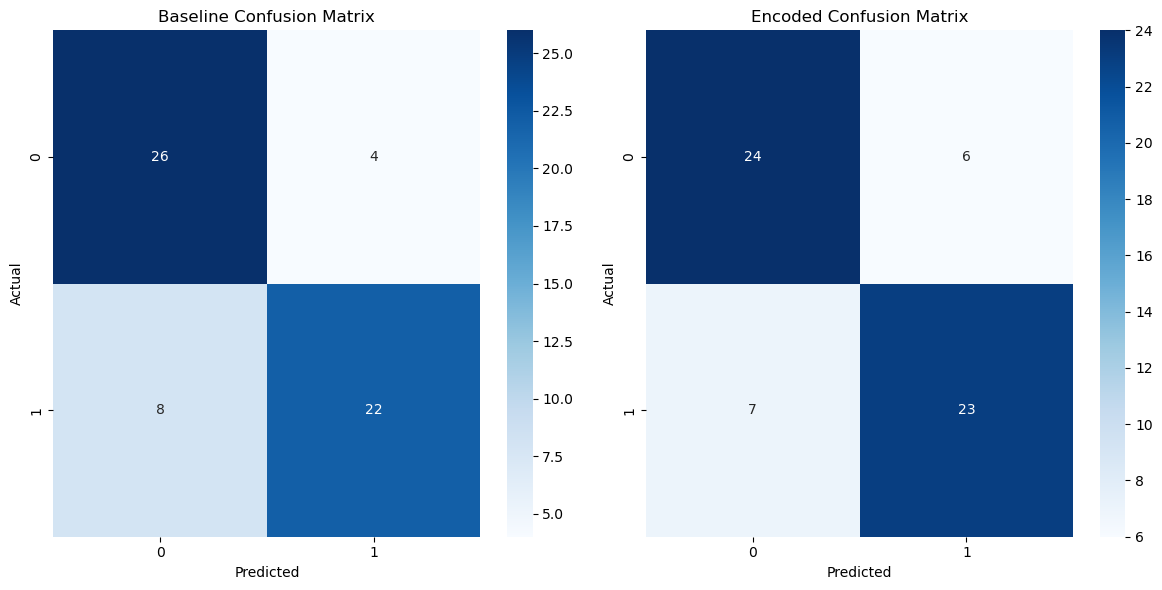

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv(preds_path)

baseline_similarity = torch.tensor(data['cos_sim_baseline'])
encoded_similarity = torch.tensor(data['cos_sim_encoded'])
targets = torch.tensor(data['label'])

threshold_baseline = sim_evaluate_thresholds(np.arange(0, 1.0, 0.05), baseline_similarity, targets)
threshold_encoded = sim_evaluate_thresholds(np.arange(0, 1.0, 0.05), encoded_similarity, targets)

baseline_predictions = (baseline_similarity >= threshold_baseline)
encoded_predictions = (encoded_similarity >= threshold_encoded)

# Generate classification reports
baseline_report = classification_report(targets, baseline_predictions)
encoded_report = classification_report(targets, encoded_predictions)

print("Baseline Classification Report:")
print(baseline_report)

print("Encoded Classification Report:")
print(encoded_report)

# Generate confusion matrices
baseline_cm = confusion_matrix(targets, baseline_predictions)
encoded_cm = confusion_matrix(targets, encoded_predictions)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(encoded_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Encoded Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [104]:
folder_path = config['dataset_folder']
train_dataset = ReframingTrainDataset(pd.read_csv(os.path.join(folder_path ,'train_vectors.csv')))
validation_dataset = ReframingTestDataset(pd.read_csv(os.path.join(folder_path ,'val_vectors.csv')))
test_dataset = ReframingTestDataset(pd.read_csv(os.path.join(folder_path ,'test_vectors.csv')))

train_loader = make_loader(train_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'])
validation_loader = make_loader(validation_dataset, batch_size= validation_dataset.__len__(), num_workers = config['num_workers'])
test_loader = make_loader(test_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'])

In [105]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cwd = os.getcwd()
f_rel_path = 'Ulm/Logging/Predictions/best_test.csv'
f_path = '/Users/mero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Work/Ulm/Logging/Predictions/best_test.csv'

best_test_df = pd.read_csv(f_path)
model_preds, model_labels = best_test_df['prediction'], best_test_df['label']
len(model_preds), len(model_labels)

(180, 180)

               precision    recall  f1-score   support

Not Reframing       0.72      0.81      0.76        90
    Reframing       0.78      0.68      0.73        90

     accuracy                           0.74       180
    macro avg       0.75      0.74      0.74       180
 weighted avg       0.75      0.74      0.74       180



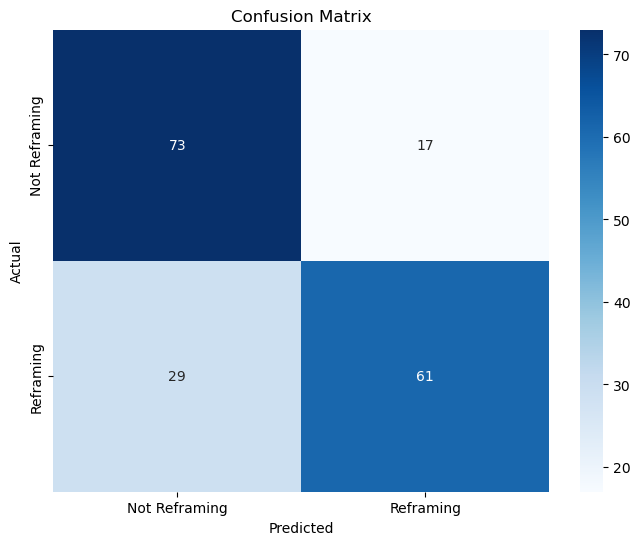

In [106]:
import matplotlib.pyplot as plt

# Calculate metrics
report = classification_report(model_labels, model_preds >= 0.5, target_names=['Not Reframing', 'Reframing'])
print(report)

# Plot confusion matrix
cm = confusion_matrix(model_labels, model_preds >= 0.5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Reframing', 'Reframing'], yticklabels=['Not Reframing', 'Reframing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [107]:
all_thoughts = torch.Tensor()
all_reframings1 = torch.Tensor()
all_reframings2 = torch.Tensor()
for batch in test_loader:
    _, embeddings = batch
    thoughts, ref1, ref2 = embeddings[0], embeddings[1], embeddings[2]
    all_thoughts = torch.cat((all_thoughts, thoughts), dim=0)
    all_reframings1 = torch.cat((all_reframings1, ref1), dim=0)
    all_reframings2 = torch.cat((all_reframings2, ref2), dim=0)
all_reframings = torch.cat((all_reframings1, all_reframings2), dim=0)

In [108]:
model_old = torch
thoughts_encoded = model(all_thoughts)
reframings_encoded = model(all_reframings)
pairs, model_cos_labels, _, _ = create_pairs(thoughts_encoded, reframings_encoded)

model_cos_logits = torch.nn.functional.cosine_similarity(pairs['thought'], pairs['reframing'], dim = 1)

threshold = sim_evaluate_thresholds(np.arange(0, 1.0, 0.05), model_cos_logits, model_labels)
print(f"Best threshold is {threshold}")

RuntimeError: Error(s) in loading state_dict for SimSkip:
	Missing key(s) in state_dict: "encoder.layer1.0.weight", "encoder.layer1.0.bias", "encoder.layer1.1.weight", "encoder.layer1.1.bias", "encoder.layer1.1.running_mean", "encoder.layer1.1.running_var". 
	Unexpected key(s) in state_dict: "encoder.l11.weight", "encoder.l11.bias", "encoder.l12.weight", "encoder.l12.bias", "encoder.l12.running_mean", "encoder.l12.running_var", "encoder.l12.num_batches_tracked". 

In [46]:
thoughts_embeddings, reframings_embeddings = all_thoughts, all_reframings
pairs, labels, _, _ = create_pairs(thoughts_embeddings, reframings_embeddings)
preds = F.cosine_similarity(pairs['thought'], pairs['reframing'], dim = 1)
threshold = sim_evaluate_thresholds(np.arange(0, 1, 0.05), preds, labels)
threshold, f1_score(labels, preds >= threshold)

(0.2, 0.8131868131868132)

               precision    recall  f1-score   support

Not Reframing       0.82      0.80      0.81        90
    Reframing       0.80      0.82      0.81        90

     accuracy                           0.81       180
    macro avg       0.81      0.81      0.81       180
 weighted avg       0.81      0.81      0.81       180



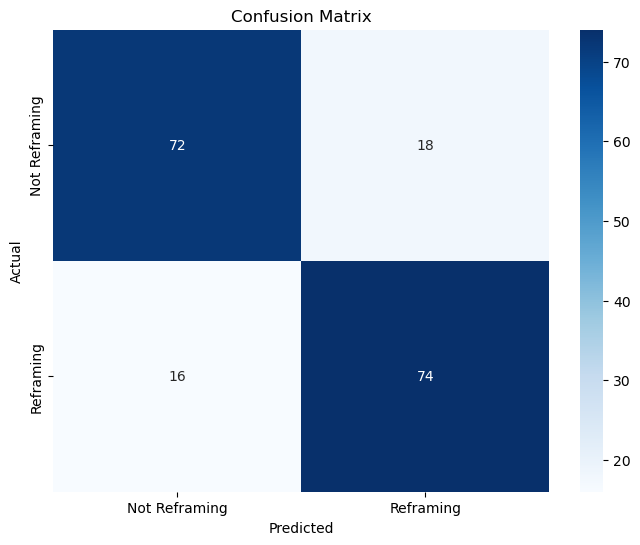

In [47]:
# Get predictions based on the new threshold
preds_class = (preds >= threshold).float()

# Calculate classification report
report = classification_report(labels, preds_class, target_names=['Not Reframing', 'Reframing'])
print(report)

# Plot confusion matrix
cm = confusion_matrix(labels, preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Reframing', 'Reframing'], yticklabels=['Not Reframing', 'Reframing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot predictions with the new threshold
plot_predictions(preds, labels, title="Predictions with New Threshold", threshold=threshold)

## 7. Running the model

### 7.1 Pipeline

In [48]:
def model_pipeline(hyperparameters, train_dataset, validation_dataset
                   , test_dataset):
  #"starting" wandb
  with wandb.init(project="SIM-SKIP Refinement", config=hyperparameters):
    config = wandb.config

    # building the model
    model, train_loader, validation_loader, test_loader, criterion, optimizer, lrs = make(config, train_dataset, validation_dataset, test_dataset)
    print(model)

    # training the model and saving the best one.
    train_model(model, train_loader, validation_loader, criterion, optimizer, lrs, config)

    best_model_artifact = wandb.Artifact('best_model_checkpoint', type='model')
    best_model_path = os.path.join(os.getcwd(), config['best_model_path'])
    best_model_artifact.add_file(best_model_path)
    wandb.log_artifact(best_model_artifact)

    # performing a quick validation run to decide threshold
    threshold, _, _ = validate(model, validation_loader, criterion)

    #test the model on downstream tasks
    test(model, test_loader, threshold)


  return model

### 7.1 Embedding the data (no need if downloaded)

In [49]:
if not downloaded:
  unembedded_path = os.path.join(config['dataset_folder'], config['dataset_name'])
  text_model = SentenceTransformer(config['text_model'])
  embedded_dataset = get_embeddings(unembedded_path, text_model, not downloaded) # only download if the data is not downloaded

else:
  embedded_path = os.path.join(config['dataset_folder'], 'reframing_dataset_embeddings.csv')
  embedded_dataset = pd.read_csv(embedded_path)

### 7.2 Creating Datasets

In [41]:
if not downloaded:
  train_dataset, validation_dataset, test_dataset = get_datasets(embedded_dataset)

else:
  folder_path = config['dataset_folder']
  train_dataset = ReframingTrainDataset(pd.read_csv(os.path.join(folder_path ,'train_vectors.csv')))
  validation_dataset = ReframingTestDataset(pd.read_csv(os.path.join(folder_path ,'val_vectors.csv')))
  test_dataset = ReframingTestDataset(pd.read_csv(os.path.join(folder_path ,'test_vectors.csv')))
  

### 7.3 Running Pipeline

#### Tracking

In [42]:
if is_wandb_watching:
    # Start Tracking
    wandb.init(project="SIM-SKIP Refinement", config = config)

#### Making the Model

In [52]:
# Creating the Model and Loaders, creating the optimizers and losses
#model, train_loader, validation_loader, test_loader, criterion, optimizer, lrs = make(config, train_dataset, validation_dataset, test_dataset)
#print(model)

In [43]:
# Create the loaders
num_workers = config['num_workers']
train_loader = make_loader(train_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'])
validation_loader = make_loader(validation_dataset, batch_size= validation_dataset.__len__(), num_workers = config['num_workers'])
test_loader = make_loader(test_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'])

In [44]:
# Make the model
model = SimSkip(
    input_dim=config['input_dim'],
    dropout_rate=config['dropout_rate'],
    projection_dim=config['projection_dim'],
    loss_temperature=config['temperature'],
    learning_rate=config['learning_rate'],
    weight_decay=config['weight_decay']
    ).to(device)

In [45]:
# instantiate the mlp
mlp_evaluator = ClassificationHead(input_dim = config['input_dim'],
                                   hidden_dim=config['classifier_hidden_dim'],
                                   output_dim=config['classifier_output_dim'],
                                   negative_samples_count=config['negative_samples_count'],
                                   dropout_rate=config['classifier_dropout'],
                                   learning_rate=config['classifier_learning_rate'],
                                   
                                   ).to(device)

In [56]:
""" OLD
# Make the loss and optimizer
criterion = ContrastiveLoss(config['temperature'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
                              weight_decay = config['weight_decay'])
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])"""

" OLD\n# Make the loss and optimizer\ncriterion = ContrastiveLoss(config['temperature'])\noptimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],\n                              weight_decay = config['weight_decay'])\nlr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])"

#### Training

In [49]:
# Training the model
model = train_model(model, train_loader, validation_loader, config)

  0%|          | 0/25 [00:00<?, ?it/s]

Loss after 00064 examples: train = 1.279 || validation = 3.159
Loss after 00128 examples: train = 1.362 || validation = 2.747
Loss after 00192 examples: train = 1.298 || validation = 2.626


  4%|▍         | 1/25 [00:04<01:39,  4.13s/it]

Loss after 00240 examples: train = 1.204 || validation = 2.574
Epoch 1/25, Average Train Loss: 1.3633, Val Loss: 2.5742
['==========']


Model at epoch0 saved with validation loss of 2.57421
Loss after 00304 examples: train = 1.126 || validation = 2.558
Loss after 00368 examples: train = 1.150 || validation = 2.574
Loss after 00432 examples: train = 1.103 || validation = 2.631


  8%|▊         | 2/25 [00:08<01:39,  4.33s/it]

Loss after 00480 examples: train = 0.871 || validation = 2.719
Epoch 2/25, Average Train Loss: 1.1124, Val Loss: 2.7187
['==========']


Loss after 00544 examples: train = 0.987 || validation = 2.822


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10e3b56d0>>
Traceback (most recent call last):
  File "/Users/mero/miniconda3/envs/uulm/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Loss after 00608 examples: train = 1.115 || validation = 3.022
Loss after 00672 examples: train = 0.968 || validation = 3.059
Loss after 00720 examples: train = 0.969 || validation = 3.065


 12%|█▏        | 3/25 [00:14<01:51,  5.06s/it]

Epoch 3/25, Average Train Loss: 0.9988, Val Loss: 3.0649
['==========']


Loss after 00784 examples: train = 0.923 || validation = 3.063
Loss after 00848 examples: train = 0.917 || validation = 3.046
Loss after 00912 examples: train = 0.951 || validation = 2.963
Loss after 00960 examples: train = 0.813 || validation = 2.862


 16%|█▌        | 4/25 [00:22<02:12,  6.30s/it]

Epoch 4/25, Average Train Loss: 0.9315, Val Loss: 2.8621
['==========']


Loss after 01024 examples: train = 0.845 || validation = 2.798
Loss after 01088 examples: train = 0.893 || validation = 2.720
Loss after 01152 examples: train = 0.901 || validation = 2.663
Loss after 01200 examples: train = 0.871 || validation = 2.589


 20%|██        | 5/25 [00:29<02:11,  6.58s/it]

Epoch 5/25, Average Train Loss: 0.8785, Val Loss: 2.5895
['==========']




Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10e3b56d0>>
Traceback (most recent call last):
  File "/Users/mero/miniconda3/envs/uulm/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Loss after 01264 examples: train = 0.905 || validation = 2.553
Loss after 01328 examples: train = 0.841 || validation = 2.526
Loss after 01392 examples: train = 0.887 || validation = 2.511
Loss after 01440 examples: train = 0.785 || validation = 2.536
Epoch 6/25, Average Train Loss: 0.8592, Val Loss: 2.5356
['==========']




 24%|██▍       | 6/25 [00:38<02:16,  7.19s/it]

Model at epoch5 saved with validation loss of 2.53562
Loss after 01504 examples: train = 0.926 || validation = 2.546
Loss after 01568 examples: train = 0.821 || validation = 2.568
Loss after 01632 examples: train = 0.786 || validation = 2.619


 28%|██▊       | 7/25 [00:43<01:58,  6.57s/it]

Loss after 01680 examples: train = 0.765 || validation = 2.585
Epoch 7/25, Average Train Loss: 0.8396, Val Loss: 2.5851
['==========']


Loss after 01744 examples: train = 0.861 || validation = 2.625
Loss after 01808 examples: train = 0.882 || validation = 2.629
Loss after 01872 examples: train = 0.871 || validation = 2.629
Loss after 01920 examples: train = 0.754 || validation = 2.626


 32%|███▏      | 8/25 [00:48<01:44,  6.16s/it]

Epoch 8/25, Average Train Loss: 0.8414, Val Loss: 2.6256
['==========']


Loss after 01984 examples: train = 0.841 || validation = 2.614
Loss after 02048 examples: train = 0.851 || validation = 2.601
Loss after 02112 examples: train = 0.790 || validation = 2.586


 36%|███▌      | 9/25 [00:54<01:35,  5.95s/it]

Loss after 02160 examples: train = 0.747 || validation = 2.552
Epoch 9/25, Average Train Loss: 0.8112, Val Loss: 2.5520
['==========']


Loss after 02224 examples: train = 0.773 || validation = 2.536
Loss after 02288 examples: train = 0.817 || validation = 2.546
Loss after 02352 examples: train = 0.788 || validation = 2.566


 40%|████      | 10/25 [00:59<01:26,  5.74s/it]

Loss after 02400 examples: train = 0.772 || validation = 2.576
Epoch 10/25, Average Train Loss: 0.8022, Val Loss: 2.5756
['==========']


Loss after 02464 examples: train = 0.779 || validation = 2.613
Loss after 02528 examples: train = 0.792 || validation = 2.650
Loss after 02592 examples: train = 0.799 || validation = 2.673


 44%|████▍     | 11/25 [01:03<01:14,  5.34s/it]

Loss after 02640 examples: train = 0.733 || validation = 2.714
Epoch 11/25, Average Train Loss: 0.7895, Val Loss: 2.7141
['==========']


Loss after 02704 examples: train = 0.800 || validation = 2.709
Loss after 02768 examples: train = 0.759 || validation = 2.709
Loss after 02832 examples: train = 0.787 || validation = 2.712


 48%|████▊     | 12/25 [01:07<01:03,  4.91s/it]

Loss after 02880 examples: train = 0.730 || validation = 2.723
Epoch 12/25, Average Train Loss: 0.7874, Val Loss: 2.7226
['==========']


Loss after 02944 examples: train = 0.763 || validation = 2.717
Loss after 03008 examples: train = 0.768 || validation = 2.745
Loss after 03072 examples: train = 0.772 || validation = 2.719


 52%|█████▏    | 13/25 [01:11<00:54,  4.54s/it]

Loss after 03120 examples: train = 0.727 || validation = 2.698
Epoch 13/25, Average Train Loss: 0.7626, Val Loss: 2.6978
['==========']


Loss after 03184 examples: train = 0.794 || validation = 2.712
Loss after 03248 examples: train = 0.781 || validation = 2.686
Loss after 03312 examples: train = 0.771 || validation = 2.684
Loss after 03360 examples: train = 0.723 || validation = 2.686


 56%|█████▌    | 14/25 [01:15<00:46,  4.27s/it]

Epoch 14/25, Average Train Loss: 0.7854, Val Loss: 2.6865
['==========']


Loss after 03424 examples: train = 0.757 || validation = 2.665
Loss after 03488 examples: train = 0.757 || validation = 2.654
Loss after 03552 examples: train = 0.772 || validation = 2.635


 60%|██████    | 15/25 [01:18<00:40,  4.09s/it]

Loss after 03600 examples: train = 0.762 || validation = 2.641
Epoch 15/25, Average Train Loss: 0.7687, Val Loss: 2.6415
['==========']


Loss after 03664 examples: train = 0.795 || validation = 2.661
Loss after 03728 examples: train = 0.845 || validation = 2.679
Loss after 03792 examples: train = 0.750 || validation = 2.721


 60%|██████    | 15/25 [01:22<00:55,  5.51s/it]

Loss after 03840 examples: train = 0.725 || validation = 2.712
Epoch 16/25, Average Train Loss: 0.7724, Val Loss: 2.7123
['==========']


Early stopping triggered after 10 epochs of no improvement.


In [56]:
# Training the classification head
mlp_evaluator = train_mlp(model, mlp_evaluator, train_loader, validation_loader, config)

  0%|          | 0/20 [00:00<?, ?it/s]

Classification Head train Loss after 00000 examples, and 0/16 batches: 0.698, Accuracy: 0.523, F1: 0.548
Classification Head train Loss after 00096 examples, and 3/16 batches: 0.594, Accuracy: 0.672, F1: 0.618
Classification Head train Loss after 00192 examples, and 6/16 batches: 0.435, Accuracy: 0.820, F1: 0.793


  5%|▌         | 1/20 [00:04<01:18,  4.14s/it]

Model at epoch0 saved with validation loss of -0.05882
Epoch 1/20:
  Average Train Loss: 0.5655
  Validation Loss: 0.6934
  Validation F1: 0.0588
  Validation Accuracy: 0.4667
Classification Head train Loss after 00240 examples, and 0/16 batches: 0.364, Accuracy: 0.898, F1: 0.904
Classification Head train Loss after 00336 examples, and 3/16 batches: 0.294, Accuracy: 0.922, F1: 0.924
Classification Head train Loss after 00432 examples, and 6/16 batches: 0.206, Accuracy: 0.953, F1: 0.955


 10%|█         | 2/20 [00:07<01:03,  3.53s/it]

Epoch 2/20:
  Average Train Loss: 0.2775
  Validation Loss: 0.6929
  Validation F1: 0.0000
  Validation Accuracy: 0.4833
Classification Head train Loss after 00480 examples, and 0/16 batches: 0.191, Accuracy: 0.961, F1: 0.962
Classification Head train Loss after 00576 examples, and 3/16 batches: 0.133, Accuracy: 0.977, F1: 0.977
Classification Head train Loss after 00672 examples, and 6/16 batches: 0.122, Accuracy: 0.969, F1: 0.970


 15%|█▌        | 3/20 [00:10<00:56,  3.32s/it]

Epoch 3/20:
  Average Train Loss: 0.1459
  Validation Loss: 0.6921
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 00720 examples, and 0/16 batches: 0.087, Accuracy: 0.984, F1: 0.984
Classification Head train Loss after 00816 examples, and 3/16 batches: 0.057, Accuracy: 1.000, F1: 1.000
Classification Head train Loss after 00912 examples, and 6/16 batches: 0.061, Accuracy: 1.000, F1: 1.000


 20%|██        | 4/20 [00:14<00:56,  3.55s/it]

Epoch 4/20:
  Average Train Loss: 0.0812
  Validation Loss: 0.6943
  Validation F1: 0.0000
  Validation Accuracy: 0.4833
Classification Head train Loss after 00960 examples, and 0/16 batches: 0.074, Accuracy: 0.977, F1: 0.977
Classification Head train Loss after 01056 examples, and 3/16 batches: 0.048, Accuracy: 0.984, F1: 0.985
Classification Head train Loss after 01152 examples, and 6/16 batches: 0.088, Accuracy: 0.961, F1: 0.961


 25%|██▌       | 5/20 [00:17<00:54,  3.62s/it]

Epoch 5/20:
  Average Train Loss: 0.0581
  Validation Loss: 0.6899
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 01200 examples, and 0/16 batches: 0.049, Accuracy: 0.992, F1: 0.992
Classification Head train Loss after 01296 examples, and 3/16 batches: 0.068, Accuracy: 0.992, F1: 0.992
Classification Head train Loss after 01392 examples, and 6/16 batches: 0.040, Accuracy: 0.992, F1: 0.992


 30%|███       | 6/20 [00:20<00:47,  3.42s/it]

Epoch 6/20:
  Average Train Loss: 0.0497
  Validation Loss: 0.6944
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 01440 examples, and 0/16 batches: 0.064, Accuracy: 0.984, F1: 0.984
Classification Head train Loss after 01536 examples, and 3/16 batches: 0.033, Accuracy: 0.992, F1: 0.992
Classification Head train Loss after 01632 examples, and 6/16 batches: 0.035, Accuracy: 0.992, F1: 0.992


 35%|███▌      | 7/20 [00:23<00:41,  3.21s/it]

Epoch 7/20:
  Average Train Loss: 0.0419
  Validation Loss: 0.6919
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 01680 examples, and 0/16 batches: 0.058, Accuracy: 0.984, F1: 0.984
Classification Head train Loss after 01776 examples, and 3/16 batches: 0.050, Accuracy: 0.984, F1: 0.985
Classification Head train Loss after 01872 examples, and 6/16 batches: 0.074, Accuracy: 0.969, F1: 0.970


 40%|████      | 8/20 [00:26<00:36,  3.08s/it]

Epoch 8/20:
  Average Train Loss: 0.0410
  Validation Loss: 0.6899
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 01920 examples, and 0/16 batches: 0.033, Accuracy: 0.992, F1: 0.992
Classification Head train Loss after 02016 examples, and 3/16 batches: 0.032, Accuracy: 0.984, F1: 0.985
Classification Head train Loss after 02112 examples, and 6/16 batches: 0.037, Accuracy: 0.992, F1: 0.992


 45%|████▌     | 9/20 [00:29<00:33,  3.03s/it]

Epoch 9/20:
  Average Train Loss: 0.0410
  Validation Loss: 0.6904
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 02160 examples, and 0/16 batches: 0.016, Accuracy: 1.000, F1: 1.000
Classification Head train Loss after 02256 examples, and 3/16 batches: 0.098, Accuracy: 0.984, F1: 0.985
Classification Head train Loss after 02352 examples, and 6/16 batches: 0.053, Accuracy: 0.977, F1: 0.976


 50%|█████     | 10/20 [00:32<00:30,  3.06s/it]

Epoch 10/20:
  Average Train Loss: 0.0544
  Validation Loss: 0.6920
  Validation F1: 0.0000
  Validation Accuracy: 0.5000
Classification Head train Loss after 02400 examples, and 0/16 batches: 0.043, Accuracy: 0.984, F1: 0.985
Classification Head train Loss after 02496 examples, and 3/16 batches: 0.072, Accuracy: 0.977, F1: 0.976
Classification Head train Loss after 02592 examples, and 6/16 batches: 0.030, Accuracy: 0.992, F1: 0.992


 50%|█████     | 10/20 [00:35<00:35,  3.56s/it]

Early stopping triggered for MLP after 10 epochs of no improvement.


#### Validation

In [344]:
# Validate the Whole model, and comparing to pure cosine similarity
threshold, avg_loss, score = validate_mlp(model, mlp_evaluator, validation_loader)
print(f"Best threshold is {threshold}, with F1 score of {score}, and an mlp cross entropy loss of {avg_loss}")

Validation Metrics:
Metric          MLP             Cosine Similarity
----------------------------------------
value_loss      0.5383          0.4968         
value_f1        0.7234          0.6531         
value_acc       0.7833          0.7167         
value_prec      1.0000          0.8421         
value_recall    0.5667          0.5333         
true_positives  17.0000         16.0000        
true_negatives  30.0000         27.0000        
false_positives 0.0000          3.0000         
false_negatives 13.0000         14.0000        

 Evaluating Thresholds ----------------
 
 For threshold(0.0)
Metrics: {'value_loss': 0.5383033752441406, 'value_f1': 0.6666666666666666, 'value_acc': 0.5, 'value_prec': 0.5, 'value_recall': 1.0, 'value_confusion': array([[ 0, 30],
       [ 0, 30]])} ) 

stats: [[ 0 30]
 [ 0 30]]


Metrics:  {'value_loss': 0.5383033752441406, 'value_f1': 0.6666666666666666, 'value_acc': 0.5, 'value_prec': 0.5, 'value_recall': 1.0, 'value_confusion': array([[ 0, 30],
  

Best threshold is 0.45, with F1 score of 0.723404255319149, and an mlp cross entropy loss of 0.0


#### Testing & Insights

In [345]:
"""current_dir = os.getcwd()

best_model_path = os.path.join(current_dir, config['best_model_path'])
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

best_mlp_path = os.path.join(current_dir, config['best_mlp_path'])
checkpoint_mlp = torch.load(best_mlp_path)
mlp_evaluator.load_state_dict(checkpoint_mlp['model_state_dict'])"""

"current_dir = os.getcwd()\n\nbest_model_path = os.path.join(current_dir, config['best_model_path'])\ncheckpoint = torch.load(best_model_path)\nmodel.load_state_dict(checkpoint['model_state_dict'])\n\nbest_mlp_path = os.path.join(current_dir, config['best_mlp_path'])\ncheckpoint_mlp = torch.load(best_mlp_path)\nmlp_evaluator.load_state_dict(checkpoint_mlp['model_state_dict'])"

In [346]:
# Test the model on downstream tasks
test(model, mlp_evaluator, test_loader)

Batch 0 accuracy: 0.7578125, F1: 0.7256637168141593
Batch 1 accuracy: 0.6538461538461539, F1: 0.5714285714285714

------------–------------–------------–


------------–------------–------------–

Final Metrics:
Metric               Value          
----------------------------------------
test_avg_f1_score    0.6838709677419355
test_avg_accuracy    0.7277777777777777
test_avg_precision   0.8153846153846154
test_avg_recall      0.5888888888888889
test_avg_loss        0.5634447932243347
test_true_positives  53             
test_true_negatives  78             
test_false_positives 12             
test_false_negatives 37             

------------–------------–------------–


------------–------------–------------–



#### Stopping Tracking

In [347]:
if is_wandb_watching:
    # Stopping the Tracking
    wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
mlp_avg_epoch_train_loss,█▄▂▂▁▁▁▁▁▁
mlp_batch_train_accuracy,▁▃▅▇▇▇▇███████▇██████████████████
mlp_batch_train_f1,▁▂▅▇▇▇▇███████▇██████████████████
mlp_batch_train_loss,█▇▅▅▄▃▃▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁
mlp_epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
mlp_epoch_validation_accuracy,▁▄█▄██████
mlp_epoch_validation_f1,█▁▁▁▁▁▁▁▁▁
mlp_epoch_validation_loss,▆▆▄█▁█▄▁▂▄
model_batch_train_loss,█▇▆▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_batch_validation_loss,▇▇█▇▆▂▂▁▂▃▄▄▄▃▂▁▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂


#### Combined

In [348]:
# All in one
# model = model_pipeline(config, train_dataset, validation_dataset, test_dataset)

In [349]:
print(model)

SimSkip(
  (encoder): SimSkipEncoder(
    (layer1): Sequential(
      (0): Linear(in_features=768, out_features=384, bias=True)
      (1): BatchNorm1d(384, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (layer2): Sequential(
      (0): Linear(in_features=384, out_features=768, bias=True)
      (1): BatchNorm1d(768, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (projector): SimSkipProjector(
    (layer1): Linear(in_features=768, out_features=768, bias=True)
    (layer2): Linear(in_features=768, out_features=128, bias=True)
  )
  (loss): ContrastiveLoss()
)


# Draft